In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import pickle
from sklearn.inspection import PartialDependenceDisplay

X = pd.read_csv('day_X.csv')
y = pd.read_csv('day_y.csv').squeeze()
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=17)

file = open('bike_rentals_rf', 'rb')
regr = pickle.load(file)
file.close()

y_test_hat = regr.predict(X_test)
np.sqrt(mean_squared_error(y_test, y_test_hat))

158.8781149936085

In [2]:
from scipy.ndimage import gaussian_filter1d

def display_pdp_ice_1d(df, feature_name, xl, yl, smooth=False, centered=False, lx=lambda x: x, ly=lambda y: y, percentiles=(0.05, 0.95), kind='average'):
    def plot_avg(y, both=False):
        if centered: y -= y[0]
        if smooth: y = gaussian_filter1d(y, sigma=2)
        
        if both: plt.plot(lx(x), ly(y), 'r--', linewidth=2)
        else: plt.plot(lx(x), ly(y), '-', color='teal', linewidth=1)
        
    def plot_ind(y):
        for yi in y:
            if centered: yi -= yi[0]
            if smooth: yi = gaussian_filter1d(yi, sigma=2)
            plt.plot(lx(x), ly(yi), '-', color='teal', linewidth=0.5)
            
    features_info = {
        "features": [feature_name],
        "kind": kind,
    }
    
    pdp = PartialDependenceDisplay.from_estimator(regr,
                                                  df,
                                                  #[df.columns.get_loc(feature_name)],
                                                  percentiles=percentiles,
                                                  #kind=kind,
                                                  **features_info,
                                                  # , method='auto'
                                                 )
    
    plt.clf()
    plt.xlabel(xl)
    plt.ylabel(yl)
    
    x = pdp.pd_results[0]['values'][0]
    
    if kind == 'average':
        plot_avg(pdp.pd_results[0]['average'][0])
    elif kind == 'individual':
        plot_ind(pdp.pd_results[0]['individual'][:][0])
    else:
        # kind == 'both'
        plot_avg(pdp.pd_results[0]['average'][0], both=True)
        plot_ind(pdp.pd_results[0]['individual'][:][0])

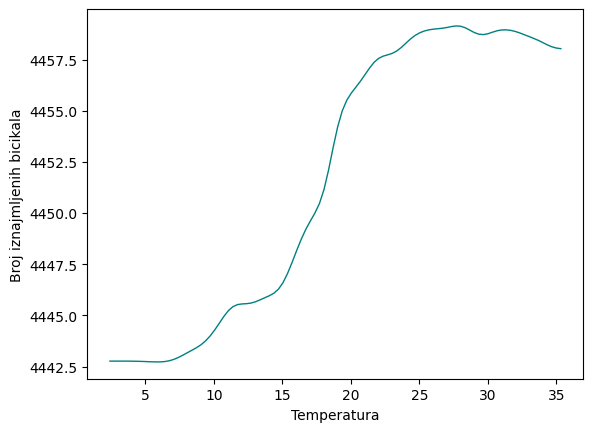

In [3]:
display_pdp_ice_1d(X, 'temp', 'Temperatura', 'Broj iznajmljenih bicikala', smooth=True, lx=lambda x: x*41, percentiles=(0, 1))

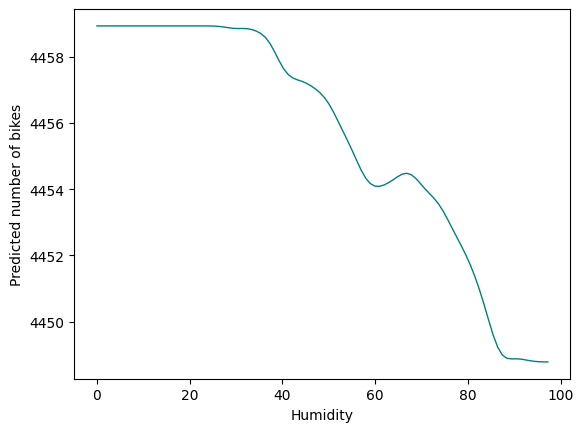

In [4]:
display_pdp_ice_1d(X, 'hum', 'Humidity', 'Predicted number of bikes', smooth=True, lx=lambda x: x*100, percentiles=(0, 1))

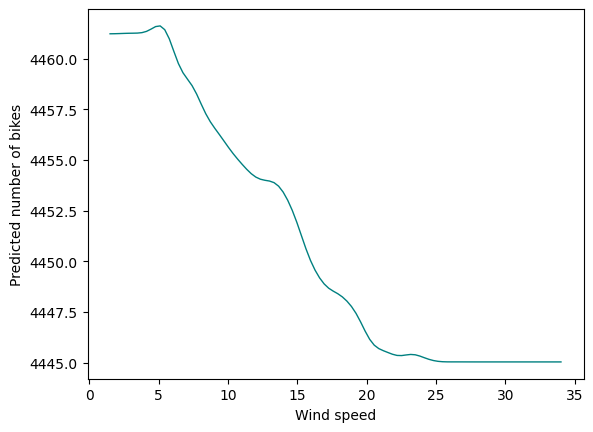

In [5]:
display_pdp_ice_1d(X, 'windspeed', 'Wind speed', 'Predicted number of bikes', smooth=True, lx=lambda x: x*67, percentiles=(0, 1))

0.6636772155761719


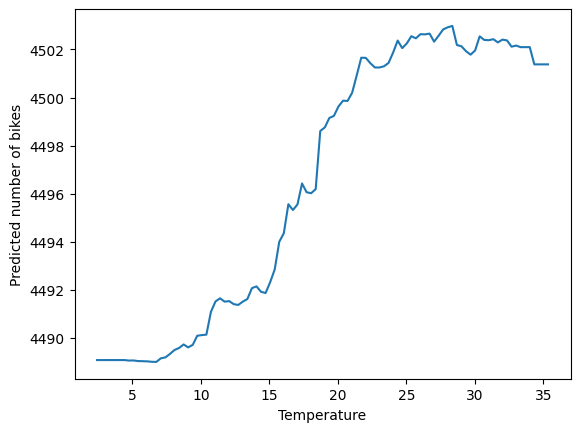

In [6]:
# PDP

import time

s = time.time()

yc_pred = []
for t in np.linspace(0.0591304, 0.861667, num=100):
    Xc = X.copy()
    Xc['temp'] = t
    yc_pred.append(np.mean(regr.predict(Xc)))

print(time.time() - s)

plt.xlabel('Temperature')
plt.ylabel('Predicted number of bikes')
plt.plot(np.linspace(0.0591304, 0.861667, num=100) * 41, yc_pred)

0.6620392799377441


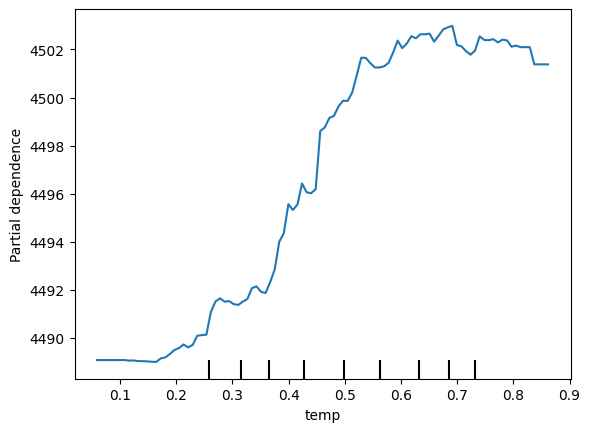

In [7]:
s = time.time()
pdp_temp = PartialDependenceDisplay.from_estimator(regr, X, [7], percentiles=(0, 1), method='brute')
print(time.time() - s)

0.1876518726348877


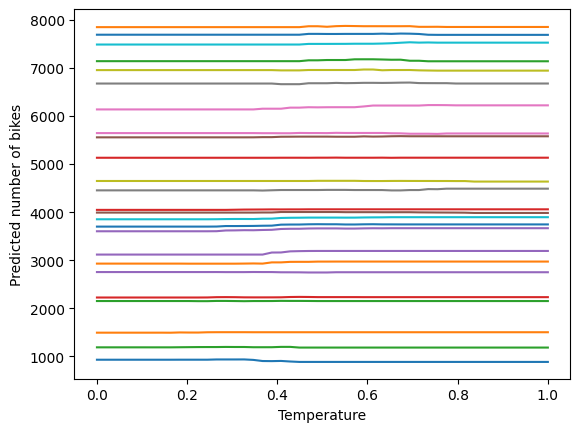

In [8]:
# ICE

import time

s = time.time()

plt.clf()

pred = []
Xc = X.copy()
Xc = Xc.iloc[::30, :]
t = np.linspace(0, 1, num=50)

for ti in t:
    Xc['temp'] = ti
    pred.append(regr.predict(Xc))

pred = np.array(pred).T.tolist()
    
plt.xlabel('Temperature')
plt.ylabel('Predicted number of bikes')

for p in pred:
    plt.plot(t, p)

print(time.time() - s)

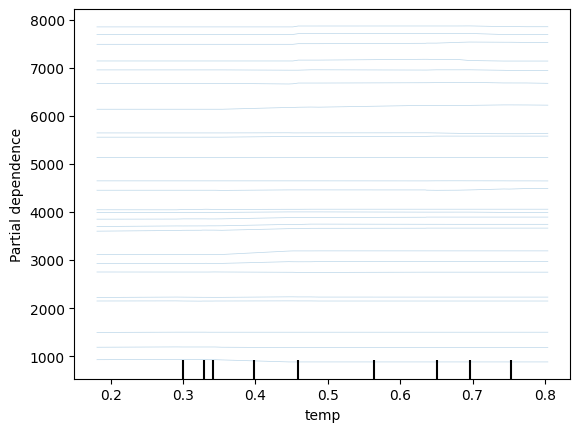

In [9]:
features_info = {
    "features": ["temp"],
    "kind": "individual",
}

PartialDependenceDisplay.from_estimator(regr, X[::30], **features_info, method='brute')

0.19117498397827148


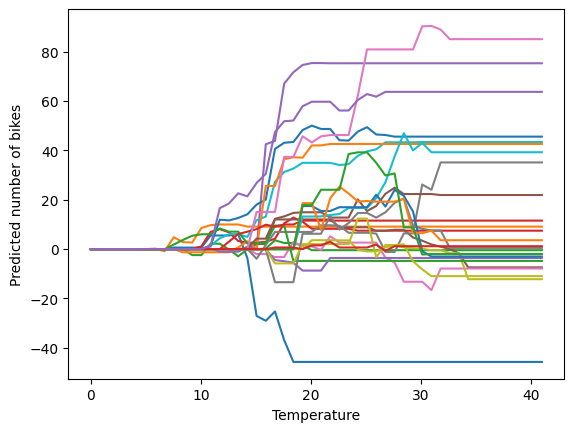

In [10]:
# Centered ICE

import time

s = time.time()

plt.clf()

pred = []
Xc = X.copy()
Xc = Xc.iloc[::30, :]
t = np.linspace(0, 1, num=50)

for ti in t:
    Xc['temp'] = ti
    pred.append(regr.predict(Xc))

pred = np.array(pred).T.tolist()
t *= 41 # Prebacivanje iz skaliranih vrijednosti

plt.xlabel('Temperature')
plt.ylabel('Predicted number of bikes')
            #if centered: yi -= yi[0]
for p in pred:
    p = [pi - p[0] for pi in p]
    plt.plot(t, p)

print(time.time() - s)

0.1922318935394287


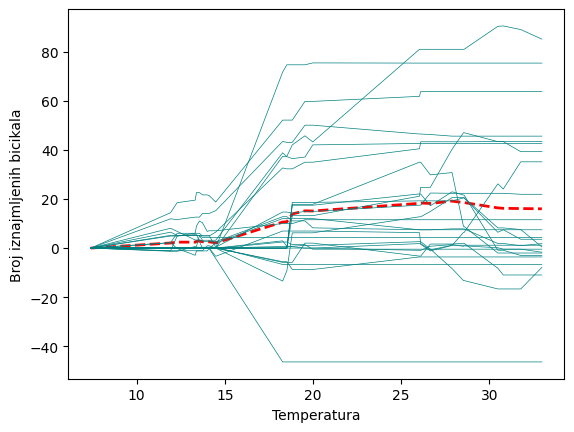

In [11]:
s = time.time()
display_pdp_ice_1d(X.iloc[::30], 'temp', 'Temperatura', 'Broj iznajmljenih bicikala', smooth=False, lx=lambda x: x*41, percentiles=(0, 1), kind='both', centered=True)
print(time.time() - s)

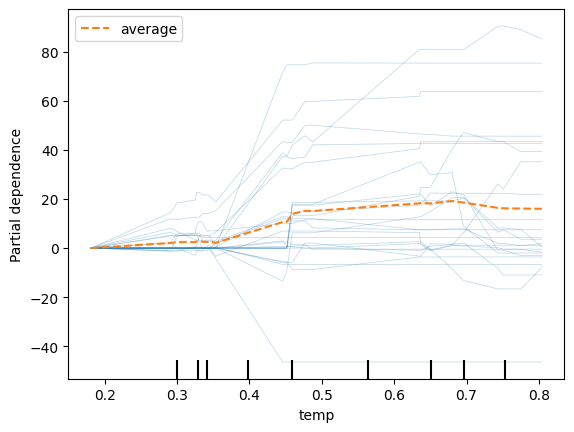

In [13]:
features_info = {
    "features": ["temp"],
    "kind": "both",
    "centered": True,
}

PartialDependenceDisplay.from_estimator(regr, X[::30], **features_info, method='brute')

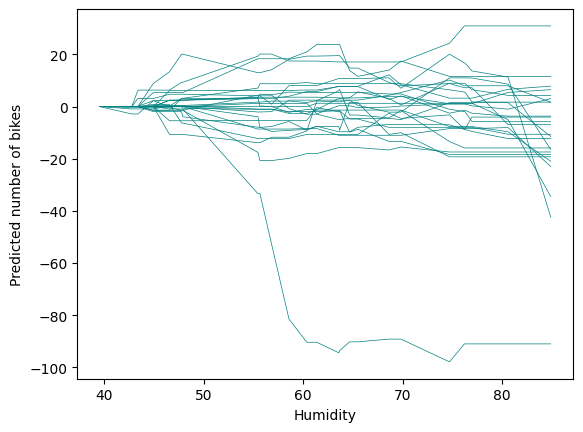

In [14]:
display_pdp_ice_1d(X.iloc[::30], 'hum', 'Humidity', 'Predicted number of bikes', smooth=False, lx=lambda x: x*100, percentiles=(0, 1), kind='individual', centered=True)

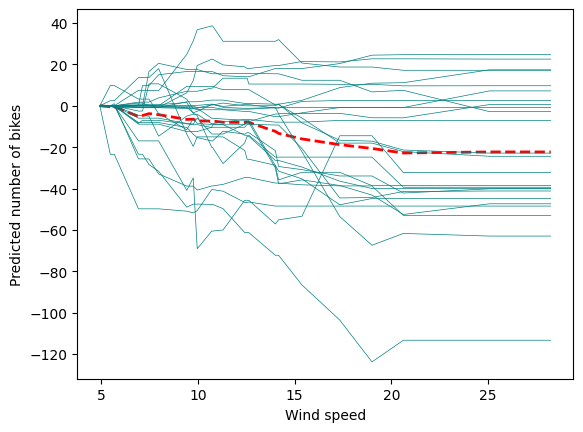

In [15]:
display_pdp_ice_1d(X.iloc[::30], 'windspeed', 'Wind speed', 'Predicted number of bikes', smooth=False, lx=lambda x: x*67, percentiles=(0, 1), kind='both', centered=True)

In [16]:
X.describe()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered
count,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000
mean,2.496580,0.500684,6.519836,0.028728,2.997264,0.683995,1.395349,0.495385,0.474354,0.627894,0.190486,848.176471,3656.172367
std,1.110807,0.500342,3.451913,0.167155,2.004787,0.465233,0.544894,0.183051,0.162961,0.142429,0.077498,686.622488,1560.256377
min,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.059130,0.079070,0.000000,0.022392,2.000000,20.000000
25%,2.000000,0.000000,4.000000,0.000000,1.000000,0.000000,1.000000,0.337083,0.337842,0.520000,0.134950,315.500000,2497.000000
50%,3.000000,1.000000,7.000000,0.000000,3.000000,1.000000,1.000000,0.498333,0.486733,0.626667,0.180975,713.000000,3662.000000
75%,3.000000,1.000000,10.000000,0.000000,5.000000,1.000000,2.000000,0.655417,0.608602,0.730209,0.233214,1096.000000,4776.500000
max,4.000000,1.000000,12.000000,1.000000,6.000000,1.000000,3.000000,0.861667,0.840896,0.972500,0.507463,3410.000000,6946.000000
